In [0]:
%run ./Connection

Adls_raw_path : abfs://bronze@nycdbda.dfs.core.windows.net/
Adls_silver_path : abfs://silver@nycdbda.dfs.core.windows.net/


In [0]:
# nyc.write.format("delta").mode('overWrite').option('overwriteSchema', 'true').save(f"{Adls_silver_path}/finalnyc/nycparking/track1/")

In [0]:
# Import the numpy, pandas, datetime, matplotlib, & seaborn packages

import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

In [0]:
nyc.repartition(1).write.mode("overwrite").option("header",'true').csv(f"{Adls_silver_path}/finalnyc")

In [0]:
# Import SparkSession
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder \
    .appName("Delta Reader") \
    .getOrCreate()

# Read Delta table into DataFrame
nyc = spark.read.format("delta") \
    .load(f"{Adls_silver_path}/finalnyc/nycparking/track1/")

# Show the DataFrame schema
nyc.printSchema()


root
 |-- Summons_Number: string (nullable = true)
 |-- Plate_ID: string (nullable = true)
 |-- Registration_State: string (nullable = true)
 |-- Plate_Type: string (nullable = true)
 |-- Issue_Date: date (nullable = true)
 |-- Violation_Code: string (nullable = true)
 |-- Vehicle_Body_Type: string (nullable = true)
 |-- Vehicle_Make: string (nullable = true)
 |-- Issuer_Precinct: string (nullable = true)
 |-- Issuer_Code: string (nullable = true)
 |-- Violation_Time: string (nullable = true)
 |-- Violation_County: string (nullable = true)



In [0]:
# Create/Replace a Temp View

nyc.createOrReplaceTempView("parking")

In [0]:
# Run a sample query on the parking table

spark.sql('select * from parking')

DataFrame[Summons_Number: string, Plate_ID: string, Registration_State: string, Plate_Type: string, Issue_Date: date, Violation_Code: string, Vehicle_Body_Type: string, Vehicle_Make: string, Issuer_Precinct: string, Issuer_Code: string, Violation_Time: string, Violation_County: string]

In [0]:
# Find the total number of tickets for each year

year_wise_tickets = spark.sql("select year(Issue_Date) as year, count(Summons_Number) as no_of_tickets from parking \
                              group by year order by year desc")

year_wise_tickets.show(70)

+----+-------------+
|year|no_of_tickets|
+----+-------------+
|2023|      3504064|
|2022|      1236343|
|2021|      4524753|
|2020|      4501771|
|2019|      1792642|
+----+-------------+



In [0]:
# Check the count of years for which the summons have been raised

year_wise_tickets.count()

5

<Figure size 640x480 with 0 Axes>

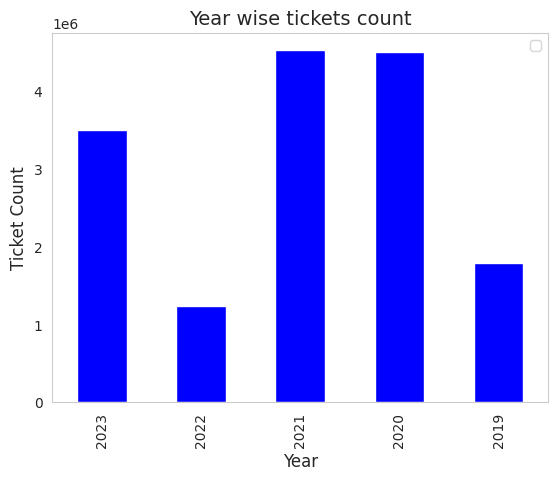

In [0]:
# create a dataframe with the year wise tickets data

year_wise_tickets_df = year_wise_tickets.toPandas()

# plot a graph
plt.clf()
year_wise_tickets_df.plot(x= 'year', y='no_of_tickets', kind='bar', color='blue')
plt.title('Year wise tickets count', fontsize = 14)
plt.xlabel("Year", fontsize = 12)
plt.ylabel("Ticket Count", fontsize = 12)
plt.legend('')
plt.show()

In [0]:
# Check the tickets issued based on plate ids

check_plate_id = spark.sql("select Plate_ID as plate_id, count(*) as ticket_count \
                          from parking \
                          group by plate_id \
                          having count(*) > 1 \
                          order by ticket_count desc")

check_plate_id.show()

+--------+------------+
|plate_id|ticket_count|
+--------+------------+
| 12125MJ|        1416|
| 86145MM|        1385|
| 91665MC|        1305|
| 83460MH|        1305|
| 96091MA|        1232|
| 96594MJ|        1146|
| 12863KA|        1144|
| 80279MM|        1134|
| 32718MM|        1067|
| 56253MG|        1064|
| 69895PC|        1064|
| 69894PC|        1046|
| 29177ML|        1036|
| 86107MM|        1034|
|      NS|        1030|
| 72479ML|        1001|
| 41950JX|         999|
| 80252MM|         992|
| 80302MM|         990|
|  AT461E|         990|
+--------+------------+
only showing top 20 rows



In [0]:
# Check the ticket counts based in registered state

registered_state_wise_tickets = spark.sql("select Registration_State as registration_state, count(*) as ticket_count \
                               from parking \
                               group by registration_state \
                               order by ticket_count desc")

registered_state_wise_tickets.show(70)

+------------------+------------+
|registration_state|ticket_count|
+------------------+------------+
|                NY|    11359510|
|                NJ|     1615173|
|                PA|      477037|
|                FL|      279967|
|                CT|      247720|
|                IN|      207153|
|                TX|      195598|
|                MA|      124858|
|                VA|      110343|
|                MD|       94016|
|                GA|       89161|
|                NC|       85261|
|                CA|       56899|
|                IL|       55906|
|                OH|       50279|
|                AZ|       47536|
|                ME|       38869|
|                SC|       33343|
|                TN|       32289|
|                MN|       28100|
|                DE|       27100|
|                MI|       23489|
|                AL|       23477|
|                WA|       23240|
|                OK|       19124|
|                RI|       18663|
|             

<Figure size 640x480 with 0 Axes>

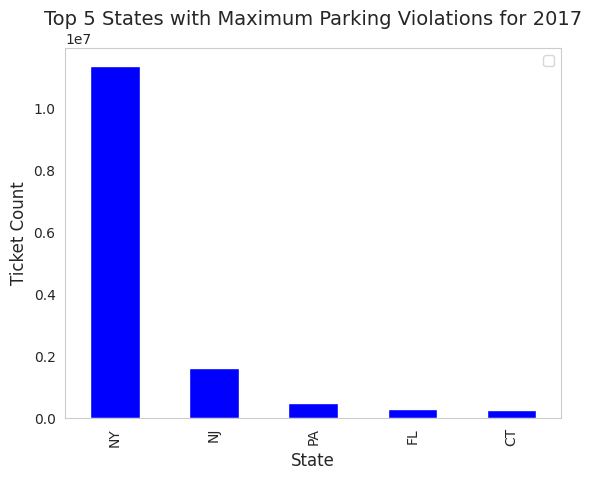

In [0]:
# create a dataframe with the ragistered state wise tickets

registered_state_wise_tickets_df = registered_state_wise_tickets.toPandas()

# plot a graph
plt.clf()
registered_state_wise_tickets_df.head(5).plot(x='registration_state', y='ticket_count', kind='bar', color ='blue')
plt.title('Top 5 States with Maximum Parking Violations for 2017', fontsize = 14)
plt.xlabel("State", fontsize = 12)
plt.ylabel("Ticket Count", fontsize = 12)
plt.legend('')
plt.show()

In [0]:
# Let us check which month in the year has maximum summons

month_wise_tickets = spark.sql("select month(Issue_Date) as month, count(*) as ticket_count \
                               from parking \
                               group by month(Issue_Date) \
                               order by ticket_count desc")

month_wise_tickets.show()

+-----+------------+
|month|ticket_count|
+-----+------------+
|    7|     3355871|
|    8|     3302216|
|   10|     2505022|
|    9|     2253652|
|   11|     2160815|
|   12|     1003686|
|    1|      491698|
|    6|      483340|
|    5|        2487|
|    3|         360|
|    4|         318|
|    2|         108|
+-----+------------+



<Figure size 640x480 with 0 Axes>

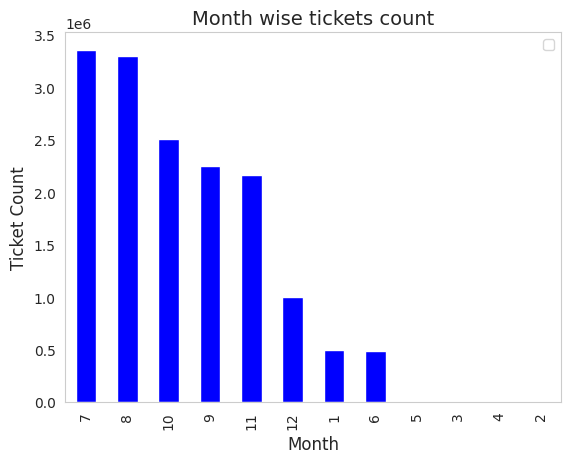

In [0]:
# create a dataframe with the month wise tickets data

month_wise_tickets_df = month_wise_tickets.toPandas()

# plot a graph
plt.clf()
month_wise_tickets_df.plot(x= 'month', y='ticket_count', kind='bar', color='blue')
plt.title('Month wise tickets count', fontsize = 14)
plt.xlabel("Month", fontsize = 12)
plt.ylabel("Ticket Count", fontsize = 12)
plt.legend('')
plt.show()

In [0]:
# Top 5 Plate Ids with maximum violations

top_5_plate_ids = spark.sql("select Plate_ID as plate_id, count(*) as ticket_count \
                             from parking \
                             group by plate_id \
                             order by ticket_count desc \
                             limit 5")
top_5_plate_ids.show()

+--------+------------+
|plate_id|ticket_count|
+--------+------------+
| 12125MJ|        1416|
| 86145MM|        1385|
| 91665MC|        1305|
| 83460MH|        1305|
| 96091MA|        1232|
+--------+------------+



<Figure size 640x480 with 0 Axes>

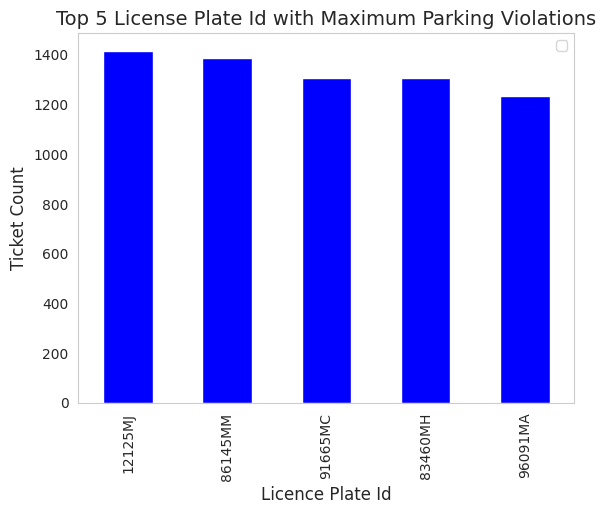

In [0]:
# create a dataframe with the month wise tickets data

top_5_plate_ids_df = top_5_plate_ids.toPandas()

# plot a graph
plt.clf()
top_5_plate_ids_df.plot(x='plate_id', y='ticket_count', kind='bar', color='blue')
plt.title("Top 5 License Plate Id with Maximum Parking Violations", fontsize = 14)
plt.xlabel("Licence Plate Id", fontsize = 12)
plt.ylabel("Ticket Count", fontsize = 12)
plt.legend('')
plt.show()

In [0]:
# Top 5 Plate Types with maximum violations

top_5_plate_types = spark.sql("select Plate_Type as plate_type, count(*) as ticket_count \
                             from parking \
                             group by plate_type \
                             order by ticket_count desc \
                             limit 5")
top_5_plate_types.show()

+----------+------------+
|plate_type|ticket_count|
+----------+------------+
|       PAS|    11939405|
|       COM|     2542016|
|       OMT|      370582|
|       SRF|      127846|
|       OMS|      113549|
+----------+------------+



<Figure size 640x480 with 0 Axes>

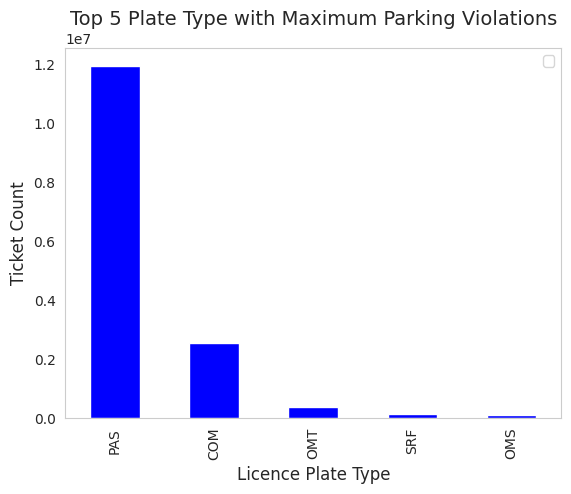

In [0]:
# create a dataframe with the month wise tickets data

top_5_plate_types_df = top_5_plate_types.toPandas()

# plot a graph
plt.clf()
top_5_plate_types_df.plot(x='plate_type', y='ticket_count', kind='bar', color='blue')
plt.title("Top 5 Plate Type with Maximum Parking Violations", fontsize = 14)
plt.xlabel("Licence Plate Type", fontsize = 12)
plt.ylabel("Ticket Count", fontsize = 12)
plt.legend('')
plt.show()

In [0]:
# How often does each violation code occur? Display the frequency of the top five violation codes

violation_code_frequency = spark.sql("select Violation_Code as violation_code, count(*) as ticket_frequency \
                                      from parking \
                                      group by violation_code \
                                      order by ticket_frequency desc \
                                      limit 5")
violation_code_frequency.show()

+--------------+----------------+
|violation_code|ticket_frequency|
+--------------+----------------+
|            21|         2506369|
|            38|         1934299|
|            14|         1621546|
|            20|         1341265|
|            40|         1267197|
+--------------+----------------+



<Figure size 640x480 with 0 Axes>

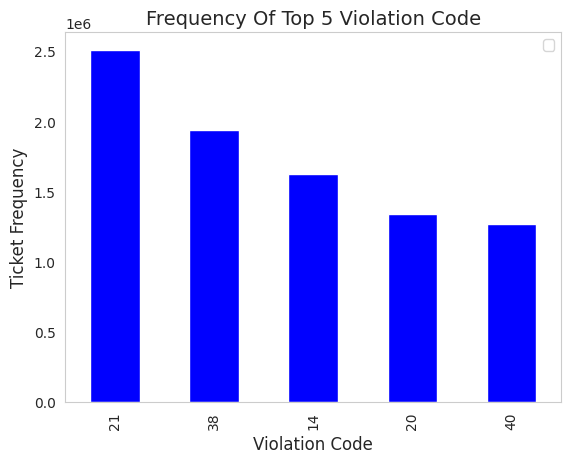

In [0]:
# create a dataframe with the violation_code_frequency

violation_code_frequency_df = violation_code_frequency.toPandas()

# plot a graph
plt.clf()
violation_code_frequency_df.plot(x='violation_code', y='ticket_frequency', kind='bar', color='blue')
plt.title('Frequency Of Top 5 Violation Code', fontsize = 14)
plt.xlabel("Violation Code", fontsize = 12)
plt.ylabel("Ticket Frequency", fontsize = 12)
plt.legend('')
plt.show()

In [0]:
# Display the frequency of the top five Vehicle Body Type getting a parking ticket

vehicle_body_type_frequency = spark.sql("select Vehicle_Body_Type as vehicle_body_type, count(*) as ticket_frequency \
                                      from parking \
                                      group by vehicle_body_type \
                                      order by ticket_frequency desc \
                                      limit 5")

vehicle_body_type_frequency.show()

+-----------------+----------------+
|vehicle_body_type|ticket_frequency|
+-----------------+----------------+
|             SUBN|         6210413|
|             4DSD|         4466652|
|              VAN|         2161919|
|             DELV|          786740|
|             PICK|          474262|
+-----------------+----------------+



<Figure size 640x480 with 0 Axes>

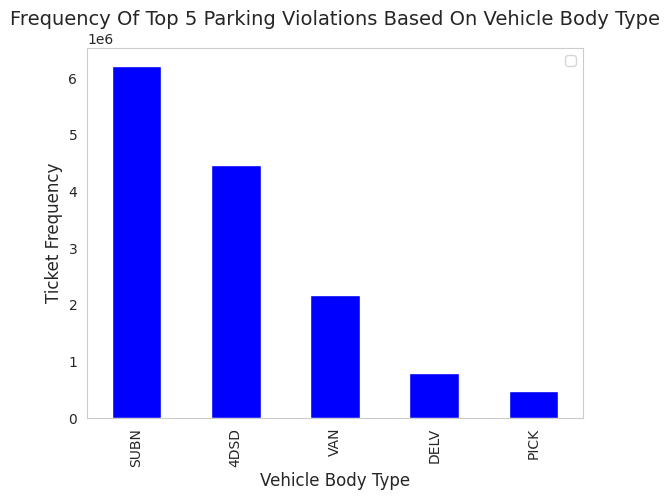

In [0]:
#create a dataframe with the vehicle_body_type_frequency

vehicle_body_type_frequency_df = vehicle_body_type_frequency.toPandas()

# plot a graph
plt.clf()
vehicle_body_type_frequency_df.head(5).plot(x='vehicle_body_type', y='ticket_frequency', kind='bar', color='blue')
plt.title('Frequency Of Top 5 Parking Violations Based On Vehicle Body Type', fontsize = 14)
plt.xlabel("Vehicle Body Type", fontsize = 12)
plt.ylabel("Ticket Frequency", fontsize = 12)
plt.legend('')
plt.show()

In [0]:
# Display the frequency of the top five Vehicle Make getting a parking ticket

vehicle_make_ticket_frequency = spark.sql("select Vehicle_Make as vehicle_make, count(*) as ticket_frequency \
                                          from parking \
                                          group by vehicle_make \
                                          order by ticket_frequency desc \
                                          limit 5")
vehicle_make_ticket_frequency.show()

+------------+----------------+
|vehicle_make|ticket_frequency|
+------------+----------------+
|        FORD|         1757964|
|       HONDA|         1712405|
|       TOYOT|         1539757|
|       NISSA|         1208917|
|       CHEVR|          893464|
+------------+----------------+



<Figure size 640x480 with 0 Axes>

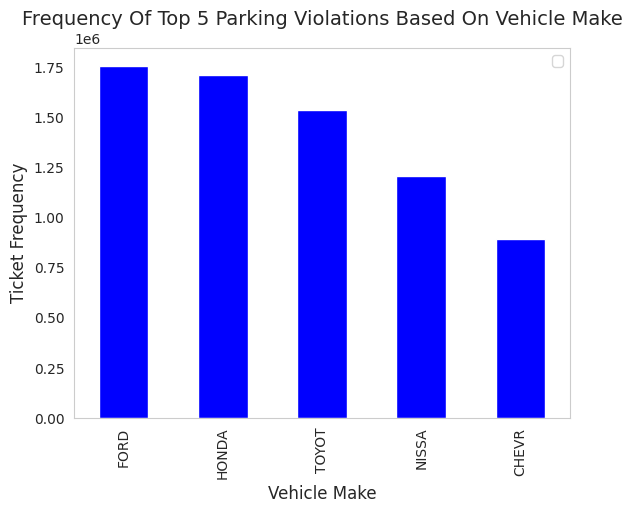

In [0]:
# create a dataframe with the vehicle_make_ticket_frequency
vehicle_make_ticket_frequency_df = vehicle_make_ticket_frequency.toPandas()

# plot a graph
plt.clf()
vehicle_make_ticket_frequency_df.plot(x='vehicle_make', y='ticket_frequency', kind='bar', color='blue')
plt.title('Frequency Of Top 5 Parking Violations Based On Vehicle Make', fontsize = 14)
plt.xlabel("Vehicle Make", fontsize = 12)
plt.ylabel("Ticket Frequency", fontsize = 12)
plt.legend('')
plt.show()

In [0]:
# Display the frequency of the top six issuer precinct

issuer_precinct_ticket_frequency = spark.sql("select Issuer_Precinct as issuer_precinct, count(*) as ticket_frequency \
                                                from parking \
                                                group by issuer_precinct \
                                                order by ticket_frequency desc")

issuer_precinct_ticket_frequency.show(5)

+---------------+----------------+
|issuer_precinct|ticket_frequency|
+---------------+----------------+
|             19|          775836|
|            114|          581322|
|             14|          577180|
|             18|          541403|
|             13|          532750|
+---------------+----------------+
only showing top 5 rows



<Figure size 640x480 with 0 Axes>

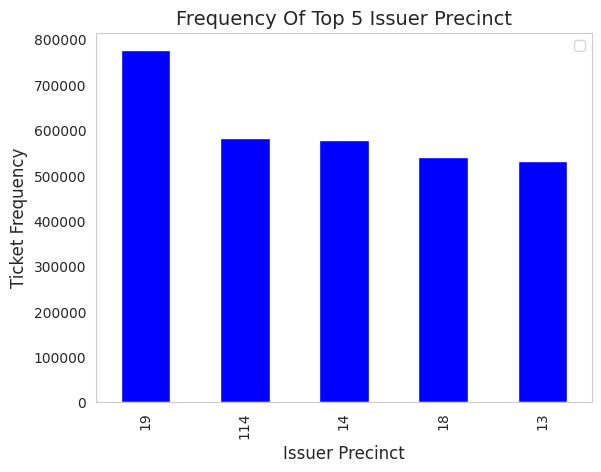

In [0]:
# create a dataframe with the issuer_precinct_ticket_frequency

issuer_precinct_ticket_frequency_df = issuer_precinct_ticket_frequency.toPandas()

# plot a graph
plt.clf()
issuer_precinct_ticket_frequency_df[issuer_precinct_ticket_frequency_df.issuer_precinct != 0].head(5)\
                                        .plot(x='issuer_precinct', y='ticket_frequency', kind='bar', color='blue')

plt.title('Frequency Of Top 5 Issuer Precinct', fontsize = 14)
plt.xlabel("Issuer Precinct", fontsize = 12)
plt.ylabel("Ticket Frequency", fontsize = 12)
plt.legend('')
plt.show()

In [0]:
# Violation code Frquency for Issuer Precinct 19 

violation_code_frequency_precinct19 = spark.sql("select Violation_Code as violation_code, count(*) as ticket_frequency \
                                                from parking \
                                                where Issuer_Precinct = 19 \
                                                group by violation_code \
                                                order by ticket_frequency desc \
                                                limit 5 ")

violation_code_frequency_precinct19.show()

+--------------+----------------+
|violation_code|ticket_frequency|
+--------------+----------------+
|            21|          109961|
|            38|           98389|
|            20|           80351|
|            14|           75857|
|            46|           69874|
+--------------+----------------+



In [0]:
# Violation code Frquency for Issuer Precinct 114

violation_code_frequency_precinct114 = spark.sql("select Violation_Code as violation_code, count(*) as ticket_frequency \
                                                from parking \
                                                where Issuer_Precinct = 114 \
                                                group by violation_code \
                                                order by ticket_frequency desc \
                                                limit 5 ")

violation_code_frequency_precinct114.show()

+--------------+----------------+
|violation_code|ticket_frequency|
+--------------+----------------+
|            21|          154870|
|            38|          115740|
|            20|           46993|
|            37|           42356|
|            40|           42093|
+--------------+----------------+



In [0]:
# Violation code Frquency for Issuer Precinct 14

violation_code_frequency_precinct14 = spark.sql("select Violation_Code as violation_code, count(*) as ticket_frequency \
                                                from parking \
                                                where Issuer_Precinct = 14 \
                                                group by violation_code \
                                                order by ticket_frequency desc \
                                                limit 5 ")

violation_code_frequency_precinct14.show()

+--------------+----------------+
|violation_code|ticket_frequency|
+--------------+----------------+
|            14|          112695|
|            31|          101272|
|            69|          101205|
|            47|           34714|
|            38|           27850|
+--------------+----------------+



In [0]:
# Violation code Frquency for Issuer Precinct 18

violation_code_frequency_precinct18 = spark.sql("select Violation_Code as violation_code, count(*) as ticket_frequency \
                                                from parking \
                                                where Issuer_Precinct = 18 \
                                                group by violation_code \
                                                order by ticket_frequency desc \
                                                limit 5 ")

violation_code_frequency_precinct18.show()

+--------------+----------------+
|violation_code|ticket_frequency|
+--------------+----------------+
|            14|          166831|
|            69|           71472|
|            31|           59294|
|            47|           32018|
|            38|           25735|
+--------------+----------------+



In [0]:
# Violation code Frquency for Issuer Precinct 13

violation_code_frequency_precinct13 = spark.sql("select Violation_Code as violation_code, count(*) as ticket_frequency \
                                                from parking \
                                                where Issuer_Precinct = 13 \
                                                group by violation_code \
                                                order by ticket_frequency desc \
                                                limit 5 ")

violation_code_frequency_precinct13.show()

+--------------+----------------+
|violation_code|ticket_frequency|
+--------------+----------------+
|            31|           84487|
|            69|           78060|
|            47|           49495|
|            38|           45662|
|            14|           42345|
+--------------+----------------+



In [0]:
# Common violation Codes across issuer precincts 19,114, 14, 18 and 13

common_precincts_violation_codes = spark.sql("select Violation_Code as violation_code , count(*) as ticket_frequency \
                                              from parking \
                                              where Issuer_Precinct in (19, 114, 14, 18, 13) \
                                              group by violation_code \
                                              order by ticket_frequency desc \
                                              limit 5 ")

common_precincts_violation_codes.show()

+--------------+----------------+
|violation_code|ticket_frequency|
+--------------+----------------+
|            14|          419191|
|            38|          313376|
|            21|          302308|
|            31|          277262|
|            69|          274526|
+--------------+----------------+



<Figure size 640x480 with 0 Axes>

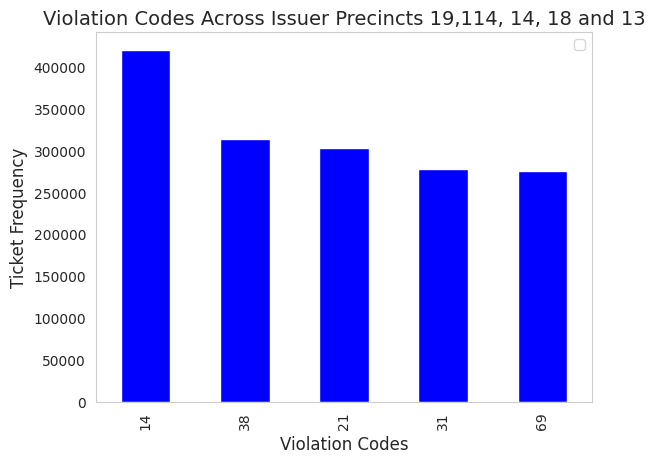

In [0]:
# create a dataframe with the common_precincts_violation_codes

common_precincts_violation_codes_df = common_precincts_violation_codes.toPandas()

# plot a graph
plt.clf()
common_precincts_violation_codes_df.plot(x='violation_code', y='ticket_frequency', kind='bar', color='blue')
plt.title('Violation Codes Across Issuer Precincts 19,114, 14, 18 and 13', fontsize = 14)
plt.xlabel("Violation Codes", fontsize = 12)
plt.ylabel("Ticket Frequency", fontsize = 12)
plt.legend('')
plt.show()

In [0]:
# First let us divide the year into seasons based on the Issue Date

# We shall divide the 4 seasons based on Issue Date as follows

#     Spring = March to May
#     Summer = June to August
#     Autumn = September to November
#     winter = December to February

seasons = spark.sql("select Summons_Number, Issue_Date, Violation_Code,  \
                        case \
                            when MONTH(TO_DATE(Issue_Date, 'MM/dd/yyyy')) between 03 and 05 \
                                then 'spring' \
                            when MONTH(TO_DATE(Issue_Date, 'MM/dd/yyyy')) between 06 and 08 \
                                then 'summer' \
                            when MONTH(TO_DATE(Issue_Date, 'MM/dd/yyyy')) between 09 and 11 \
                                then 'autumn' \
                            when MONTH(TO_DATE(Issue_Date, 'MM/dd/yyyy')) in (1,2,12) \
                                then 'winter' \
                            else 'unknown' \
                        end as Season \
                        from parking")

seasons.show(5)

+--------------+----------+--------------+------+
|Summons_Number|Issue_Date|Violation_Code|Season|
+--------------+----------+--------------+------+
|    1455214498|2019-06-03|            20|summer|
|    1446885938|2019-06-04|            14|summer|
|    1455244922|2019-06-07|            14|summer|
|    1455273119|2019-06-08|            50|summer|
|    1453307898|2019-06-09|            27|summer|
+--------------+----------+--------------+------+
only showing top 5 rows



In [0]:
# Create/Replace a Temp View

seasons.createOrReplaceTempView("nyc_seasons")

In [0]:
# Frequency of tickets based on season

parking_violations_on_seasons = spark.sql("select Season as season, count(*) as ticket_frequency \
                                           from nyc_seasons \
                                           group by season \
                                           order by ticket_frequency desc")
parking_violations_on_seasons.show()

+------+----------------+
|season|ticket_frequency|
+------+----------------+
|summer|         7141427|
|autumn|         6919489|
|winter|         1495492|
|spring|            3165|
+------+----------------+



In [0]:
# Three most commonly occuring violation for spring i.e. from March to May

spring = spark.sql("select Violation_Code as violation_code, count(*) as violation_count \
                    from nyc_seasons \
                    where Season == 'spring' \
                    group by violation_code \
                    order by violation_count desc \
                    limit 5 ")
spring.show()

+--------------+---------------+
|violation_code|violation_count|
+--------------+---------------+
|            14|            437|
|            20|            385|
|            40|            373|
|            46|            352|
|            98|            326|
+--------------+---------------+



In [0]:
# Three most commonly occuring violation for winter i.e. from December to February

winter = spark.sql("select Violation_Code as violation_code, count(*) as violation_count \
                    from nyc_seasons \
                    where Season == 'winter' \
                    group by violation_code \
                    order by violation_count desc \
                    limit 5 ")
winter.show()

+--------------+---------------+
|violation_code|violation_count|
+--------------+---------------+
|            71|         200568|
|            21|         186367|
|            38|         172696|
|            14|         143207|
|            40|         132731|
+--------------+---------------+



In [0]:
# Three most commonly occuring violation for summer i.e. from June to September

summer = spark.sql("select Violation_Code as violation_code, count(*) as violation_count \
                    from nyc_seasons \
                    where Season == 'summer' \
                    group by violation_code \
                    order by violation_count desc \
                    limit 5 ")
summer.show()

+--------------+---------------+
|violation_code|violation_count|
+--------------+---------------+
|            21|        1222394|
|            38|         883612|
|            14|         736707|
|            20|         628091|
|            40|         527776|
+--------------+---------------+



In [0]:
# Three most commonly occuring violation for autumn i.e. from September to November

autumn = spark.sql("select Violation_Code as violation_code, count(*) as violation_count \
                    from nyc_seasons \
                    where Season == 'autumn' \
                    group by violation_code \
                    order by violation_count desc \
                    limit 5 ")
autumn.show()

+--------------+---------------+
|violation_code|violation_count|
+--------------+---------------+
|            21|        1097539|
|            38|         877988|
|            14|         741195|
|            40|         606317|
|            20|         600099|
+--------------+---------------+



In [0]:
# Total occurrences of the three most common violation codes.  
top_3_common_violations = spark.sql("select Violation_Code as violation_code, count(*) as ticket_frequency \
                                    from parking \
                                    group by violation_code \
                                    order by ticket_frequency desc \
                                    limit 3")
top_3_common_violations.show()

+--------------+----------------+
|violation_code|ticket_frequency|
+--------------+----------------+
|            21|         2506369|
|            38|         1934299|
|            14|         1621546|
+--------------+----------------+



In [0]:
# From the above result we know the top five violation codes.

# As per the website, the average prices for the three violation codes are as follows:
#   For violation code 21 = (65 + 45)/2 = $55
#   For violation code 38 = (65 + 35)/2 = $50
#   For violation code 14 = (115 + 115)/2 = $115

from pyspark.sql.functions import when

common_violations_fine_amount = top_3_common_violations.withColumn("fine_amount",
    when(top_3_common_violations.ticket_frequency == 21, top_3_common_violations.ticket_frequency * 55)
    .when(top_3_common_violations.ticket_frequency == 38, top_3_common_violations.ticket_frequency * 50)
    .otherwise(top_3_common_violations.ticket_frequency * 115)
)

common_violations_fine_amount.show()

+--------------+----------------+-----------+
|violation_code|ticket_frequency|fine_amount|
+--------------+----------------+-----------+
|            21|         2506369|  288232435|
|            38|         1934299|  222444385|
|            14|         1621546|  186477790|
+--------------+----------------+-----------+



In [0]:
# Total amount collected for the three violation codes with maximum tickets

from pyspark.sql import functions as F

total = common_violations_fine_amount.agg(F.sum("fine_amount")).collect()
print('Total amount collected for the three violation codes with maximum tickets : ', total)

Total amount collected for the three violation codes with maximum tickets :  [Row(sum(fine_amount)=697154610)]


In [0]:
# Display the frequency of the top five Issuer Code getting a parking ticket

Issuer_Code_ticket_frequency = spark.sql("select Issuer_Code as issuer_code, count(*) as ticket_frequency \
                                          from parking \
                                          group by issuer_code \
                                          order by ticket_frequency desc \
                                          limit 5")
Issuer_Code_ticket_frequency.show()


+-----------+----------------+
|issuer_code|ticket_frequency|
+-----------+----------------+
|     362237|           31578|
|     355542|           29358|
|     345534|           25942|
|     353177|           24569|
|     346199|           24415|
+-----------+----------------+



<Figure size 640x480 with 0 Axes>

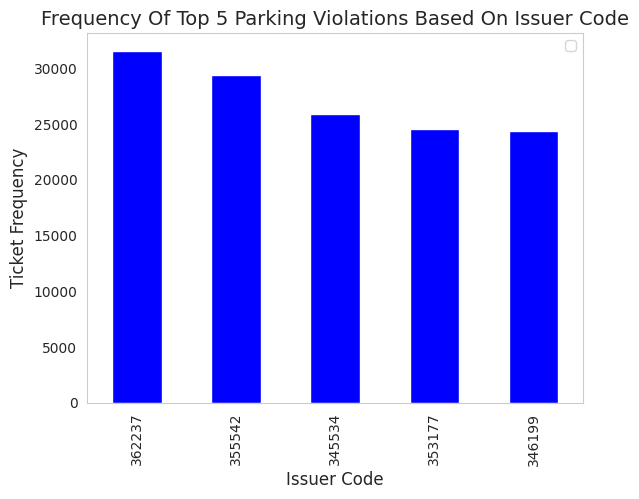

In [0]:
# create a dataframe with the Issuer_Code_ticket_frequency
Issuer_Code_ticket_frequency_df = Issuer_Code_ticket_frequency.toPandas()

# plot a graph
plt.clf()
Issuer_Code_ticket_frequency_df.plot(x='issuer_code', y='ticket_frequency', kind='bar', color='blue')
plt.title('Frequency Of Top 5 Parking Violations Based On Issuer Code', fontsize = 14)
plt.xlabel("Issuer Code", fontsize = 12)
plt.ylabel("Ticket Frequency", fontsize = 12)
plt.legend('')
plt.show()


---------------------------------------------------------------------------
NameError Traceback (most recent call last)
File , line 2
 1 # create a dataframe with the Violation_County_ticket_frequency
----> 2 Violation_County_ticket_frequency_df = Violation_County_ticket_frequency.toPandas()
 4 # plot a graph
 5 plt.clf()

NameError: name 'Violation_County_ticket_frequency' is not defined

In [0]:
# Display the frequency of the top five Vehicle Body Type getting a parking ticket

violation_county_type_frequency = spark.sql("select Violation_County as violation_county, count(*) as ticket_frequency \
                                      from parking \
                                      group by violation_county \
                                      order by ticket_frequency desc \
                                      limit 5")

violation_county_type_frequency.show()

+----------------+----------------+
|violation_county|ticket_frequency|
+----------------+----------------+
|              NY|         6311572|
|               K|         3522537|
|               Q|         3493562|
|              BX|         1914241|
|               R|          263537|
+----------------+----------------+



<Figure size 640x480 with 0 Axes>

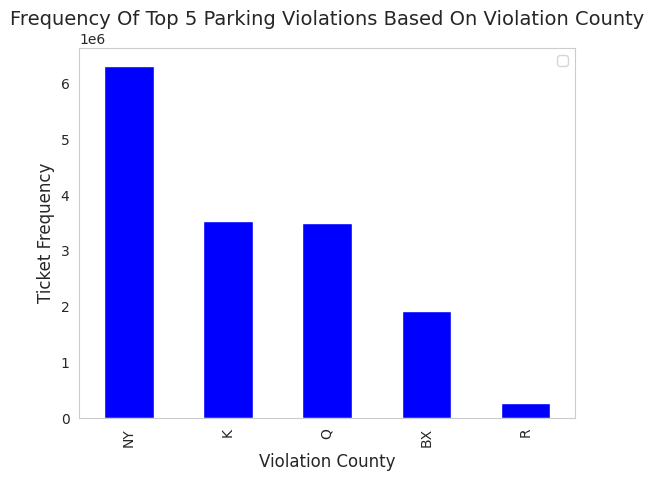

In [0]:
# create a dataframe with the violation_county_type_frequency
violation_county_type_frequency_df = violation_county_type_frequency.toPandas()

# plot a graph
plt.clf()
violation_county_type_frequency_df.plot(x='violation_county', y='ticket_frequency', kind='bar', color='blue')
plt.title('Frequency Of Top 5 Parking Violations Based On Violation County', fontsize = 14)
plt.xlabel("Violation County", fontsize = 12)
plt.ylabel("Ticket Frequency", fontsize = 12)
plt.legend('')
plt.show()